### Data Pre-processing ###
This notebook takes raw photometric (energy amounts at different wavelengths of the visible spectrum) from stellar objects and prepares it for analysis in different Gaussian mixture clustering models 
    - raw data is crossmatched for common objects with data from a catalog of standard (non-variable), stacked stars
    - the data is handled in Spark dataframes, then converted to numpy arrays and saved for analysis in GMM_plots notebook
    - a plot of the color distributions for the catalog stars is generated at end
  Data sources:  
  - Raw data is a 2 x 10 sqr deg section of sky uploaded here from local drive, but previously downloaded from the SDSS SkyServer online database using an SQL query (detailed query in appendix of report)
     The flux is taken from a single observations of objects
      
  - Standard star data is from Stripe 82 catalog by Ivezic et all 2007 available at     http://www.astro.washington.edu/users/ivezic/sdss/catalogs/stripe82.html
     This data is from repeated observations which have been averaged and calibrated
  

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
# to load data as dataframes
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)
from pyspark.sql import functions as fn

path = "data/"
#in IBM workbook 
#path = "/resources/data/XD/"
noisypath= os.path.join(path, "DR7_raw.csv")
stdpath = os.path.join(path,"stripe82calibStars_v2.6.dat.gz" )

**Definitions for loading and converting data

In [2]:
# converts estimated size to common units
def sizeconv(num, suffix='B'):
    for unit in ['','K','M','G','T','P','E','Z']:
        if abs(num) < 1024.0:
            return "%3.1f%s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)

In [3]:
# Methods to convert a Dataframe to a local numpy ndarray, 
# from portion of spark_sklearn (https://github.com/databricks/spark-sklearn)
# only intended for small files

#convert data types
def analyze_element(x):
  if type(x) is float:
    return (x, np.double)
  if type(x) is int:
    return (x, np.int)
  if type(x) is long:
    return (x, np.long)
  if type(x) is DenseVector:
    return (x.toArray(), (np.double, len(x.toArray())))
  raise ValueError("The type %s could not be understood. Element was %s" % (type(x), x))

def analyze_df(df):
  """ Converts a dataframe into a numpy array.
  """
  rows = df.collect()
  conversions = [[analyze_element(x) for x in row] for row in rows]
  types = [t for d, t in conversions[0]]
  data = [tuple([d for d, t in labeled_elts]) for labeled_elts in conversions]
  names = list(df.columns)
  dt = np.dtype({'names': names, 'formats': types})
  arr = np.array(data, dtype=dt)
  return arr

    
def df_to_numpy(df, *args):
  """ Converts a dataframe into a (local) numpy array. Each column is named after the same
  column name in the data frame.

  The varargs provide (in order) the list of columns to extract from the dataframe.
  If none are provided, all the columns from the dataframe are extracted.

  This method only handles basic numerical types, or dense vectors with the same length.

  Note: it is not particularly optimized, do not push it too hard.

  :param df: a pyspark.sql.DataFrame object
  :param args: a list of strings that are column names in the dataframe
  :return: a structured numpy array with the content of the data frame.

  Example:
  >>> z = conv.df_to_numpy(df)
  >>> z['x'].dtype, z['x'].shape
  >>> z = conv.df_to_numpy(df, 'y')
  >>> z['y'].dtype, z['y'].shape
  """
  column_names = df.columns
  if not args:
    args = column_names
  column_nameset = set(column_names)
  for name in args:
    assert name in column_nameset, (name, column_names)
  # Just get the interesting columns
  projected = df.select(*args)

  return analyze_df(projected)

In [5]:
# From astroML library, for matching common objects between the raw data and the standard star catalog
# Original at astroML: http://astroML.github.com
from scipy.spatial import cKDTree

def crossmatch(X1, X2, max_distance=np.inf):
    """Cross-match the values between X1 and X2

    By default, this uses a KD Tree for speed.

    Parameters
    ----------
    X1 : array_like
        first dataset, shape(N1, D)
    X2 : array_like
        second dataset, shape(N2, D)
    max_distance : float (optional)
        maximum radius of search.  If no point is within the given radius,
        then inf will be returned.

    Returns
    -------
    dist, ind: ndarrays
        The distance and index of the closest point in X2 to each point in X1
        Both arrays are length N1.
        Locations with no match are indicated by
        dist[i] = inf, ind[i] = N2
    """
    X1 = np.asarray(X1, dtype=float)
    X2 = np.asarray(X2, dtype=float)

    N1, D = X1.shape
    N2, D2 = X2.shape

    if D != D2:
        raise ValueError('Arrays must have the same second dimension')

    kdt = cKDTree(X2)

    dist, ind = kdt.query(X1, k=1, distance_upper_bound=max_distance)

    return dist, ind


**Load raw/noisy data (previously downloaded from SDSS) and correct for extinction

In [6]:
# Load DR7 data as csv into a dataframe

df_noisy  = sqlContext.read.load(noisypath, format = "com.databricks.spark.csv",header="true", inferSchema = "true")

#Select stars/unresolved light sources from the sample data
df_noisy=df_noisy.filter(df_noisy.type==6)
df_noisy.registerTempTable("noisy")
df_noisy.show(2)
#print ("Schema of df_noisy: %s" % (df_noisy.dtypes))
print ("Shape of df_noisy: %d rows" % (df_noisy.count()))
#print ("Size of df_noisy: %s" % (sizeconv(sys.getsizeof(df_noisy))))

+--------+--------+----+-------+------+------+------+------+------+-----+-----+-----+-----+-----+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+----+--------+
|      ra|     dec| run|rExtSFD|  uRaw|  gRaw|  rRaw|  iRaw|  zRaw| uErr| gErr| rErr| iErr| zErr|uRawPSF|gRawPSF|rRawPSF|iRawPSF|zRawPSF|upsfErr|gpsfErr|rpsfErr|ipsfErr|zpsfErr|type|ISOLATED|
+--------+--------+----+-------+------+------+------+------+------+-----+-----+-----+-----+-----+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+----+--------+
|0.009223|0.742139|2662|  0.076| 25.24|22.767|21.115|19.683|18.797|0.884|0.163|0.052|0.029|0.042| 25.133|  22.75| 21.142| 19.702| 18.835|  0.888|  0.153|  0.056|   0.03|  0.043|   6|       1|
|0.012325|-0.43537|2662|  0.111|26.008|23.707|22.472|22.233|21.341|0.709|0.375|0.165|0.216|0.379| 25.869| 23.667| 22.451| 22.197| 21.459|  0.771|  0.349|   0.15|  0.196|  0.393|   6|       1|
+--------+--------+----+-------+------+-

In [7]:
#  Create dataframe of the PSF (point spread function) of flux values
Xcol = []
for band in 'ugriz':
    Xcol += [band + 'RawPSF']
#print Xcol

# Create dataframe of psf errors
XerrCol = []
for band in 'ugriz':
    XerrCol += [band + 'psfErr']
#print XerrCol

Xerr = df_noisy.select(XerrCol)
print Xerr.show(2)

+-------+-------+-------+-------+-------+
|upsfErr|gpsfErr|rpsfErr|ipsfErr|zpsfErr|
+-------+-------+-------+-------+-------+
|  0.888|  0.153|  0.056|   0.03|  0.043|
|  0.771|  0.349|   0.15|  0.196|  0.393|
+-------+-------+-------+-------+-------+
only showing top 2 rows

None


In [8]:
# Adjust extinction terms from Berry et al, arXiv 1111.4985 (1.810, 1.400, 1.0, 0.759, 0.561) with \
# specific SDSS extinction value 'rExtSFD', then subtract from RawPsf values of X


X = sqlContext.sql("SELECT (uRawPSF - (rExtSFD *1.810)) as uRawPSF, \
                        (gRawPSF - (rExtSFD *1.400)) as gRawPSF, \
                        (rRawPSF - (rExtSFD *1.0)) as rRawPSF, \
                        (iRawPSF - (rExtSFD *0.759)) as iRawPSF, \
                        (zRawPSF - (rExtSFD *0.561)) as zRawPSF \
                        FROM noisy")
X.show(2)


#print ("Schema of X: %s" % (X.dtypes))
print ("Shape of X: %d rows" % (X.count()))
#print ("Size of X: %s" % (sizeconv(sys.getsizeof(X))))

+--------+-------+-------+------------------+---------+
| uRawPSF|gRawPSF|rRawPSF|           iRawPSF|  zRawPSF|
+--------+-------+-------+------------------+---------+
|24.99544|22.6436| 21.066|19.644316000000003|18.792364|
|25.66809|23.5116|  22.34|         22.112751|21.396729|
+--------+-------+-------+------------------+---------+
only showing top 2 rows

Shape of X: 86290 rows


**Load standard star catalog and correct for extinction

In [9]:
#Read the zipped file
#stdpath = os.path.join(path,"stripe82calibStars_v2.6.dat.gz" )
lines = sc.textFile(stdpath)

#Remove header lines, each of which starts with "###".
dataLines = lines.filter(lambda x: "###" not in x)

print ("Rows in standard RDD w/o header: %d rows" % (dataLines.count()))
print dataLines.first()

Rows in standard RDD w/o header: 1006849 rows
CALIBSTARS 308.5002136  -1.2277210 0.0320 0.0320   4  0.587   0  0.066  0.066  0.000  0.000   0.0   4 22.301 22.265  0.057  0.168   1.9   4 20.814 20.809  0.020  0.049   1.2   4 20.187 20.202  0.019  0.053   2.0   4 19.878 19.809  0.047  0.139   2.4 


In [10]:
from pyspark.sql import Row
# Transform data with UDF
def transformToNumeric(inputStr) :
    attList = inputStr.split()    
    #Filter out columns not wanted at this stage
    values = Row(float(attList[1]), float(attList[2]), float(attList[3]), float(attList[4]), int(attList[5]), float(attList[6]),\
                 int(attList[7]),  float(attList[8]),  float(attList[9]),  float(attList[10]), float(attList[11]), float(attList[12]),\
                 int(attList[13]), float(attList[14]), float(attList[15]), float(attList[16]), float(attList[17]), float(attList[18]),\
                 int(attList[19]), float(attList[20]), float(attList[21]), float(attList[22]), float(attList[23]), float(attList[24]),\
                 int(attList[25]), float(attList[26]), float(attList[27]), float(attList[28]), float(attList[29]), float(attList[30]),\
                 int(attList[31]), float(attList[32]), float(attList[33]), float(attList[34]), float(attList[35]), float(attList[36]))
    return values

attrName = ('RA', 'DEC', 'RArms', 'DECrms', 'Ntot', 'A_r', 'Nobs_u', 'mmed_u', 'mmu_u', 'msig_u', 'mrms_u', 'mchi2_u',\
                'Nobs_g', 'mmed_g', 'mmu_g', 'msig_g', 'mrms_g', 'mchi2_g', 'Nobs_r', 'mmed_r', 'mmu_r', 'msig_r', 'mrms_r',\
                'mchi2_r', 'Nobs_i', 'mmed_i', 'mmu_i', 'msig_i', 'mrms_i', 'mchi2_i', 'Nobs_z', 'mmed_z', 'mmu_z', 'msig_z',\
                'mrms_z', 'mchi2_z')

data = dataLines.map(transformToNumeric)

# Combine the data and attribute and construct a data frame.
stdDF_full = sqlContext.createDataFrame(data, attrName)

print ("Rows in standard dataframe w/o header: %d rows" % (stdDF_full.count()))
stdDF_full.show(2)


Rows in standard dataframe w/o header: 1006849 rows
+-----------+----------+-----+------+----+-----+------+------+------+------+------+-------+------+------+------+------+------+-------+------+------+------+------+------+-------+------+------+------+------+------+-------+------+------+------+------+------+-------+
|         RA|       DEC|RArms|DECrms|Ntot|  A_r|Nobs_u|mmed_u| mmu_u|msig_u|mrms_u|mchi2_u|Nobs_g|mmed_g| mmu_g|msig_g|mrms_g|mchi2_g|Nobs_r|mmed_r| mmu_r|msig_r|mrms_r|mchi2_r|Nobs_i|mmed_i| mmu_i|msig_i|mrms_i|mchi2_i|Nobs_z|mmed_z| mmu_z|msig_z|mrms_z|mchi2_z|
+-----------+----------+-----+------+----+-----+------+------+------+------+------+-------+------+------+------+------+------+-------+------+------+------+------+------+-------+------+------+------+------+------+-------+------+------+------+------+------+-------+
|308.5002136| -1.227721|0.032| 0.032|   4|0.587|     0| 0.066| 0.066|   0.0|   0.0|    0.0|     4|22.301|22.265| 0.057| 0.168|    1.9|     4|20.814|20.809| 

In [11]:
# Trim standard star data to to sample area

stdData = stdDF_full.filter(stdDF_full.RA > 0).filter(stdDF_full.RA < 10).filter(stdDF_full.DEC > -1).filter(stdDF_full.DEC < 1)

stdData.registerTempTable("stdData")
print ("Rows in stdData: %d rows" % (stdData.count()))

stdData.show(2)


Rows in stdData: 40614 rows
+--------+---------+-----+------+----+-----+------+------+------+------+------+-------+------+------+------+------+------+-------+------+------+------+------+------+-------+------+------+------+------+------+-------+------+------+------+------+------+-------+
|      RA|      DEC|RArms|DECrms|Ntot|  A_r|Nobs_u|mmed_u| mmu_u|msig_u|mrms_u|mchi2_u|Nobs_g|mmed_g| mmu_g|msig_g|mrms_g|mchi2_g|Nobs_r|mmed_r| mmu_r|msig_r|mrms_r|mchi2_r|Nobs_i|mmed_i| mmu_i|msig_i|mrms_i|mchi2_i|Nobs_z|mmed_z| mmu_z|msig_z|mrms_z|mchi2_z|
+--------+---------+-----+------+----+-----+------+------+------+------+------+-------+------+------+------+------+------+-------+------+------+------+------+------+-------+------+------+------+------+------+-------+------+------+------+------+------+-------+
| 2.01E-4|-0.838723|0.045| 0.038|  21|0.123|    20|19.835|19.834|  0.01| 0.046|    1.1|    20|18.846|18.849| 0.005| 0.028|    1.2|    20|18.473| 18.47| 0.004| 0.022|    1.5|    20|18.313|18.31

In [12]:
# Adjust extinction terms from Berry et al, arXiv 1111.4985 (1.810, 1.400, 1.0, 0.759, 0.561) with specfic SDSS extinction value
#'rExtSFD', then subtract from RawPsf values of X
#============================================================================

# Columns of the PSF (point spread function)
Ycol = []
for band in 'ugriz':
    Ycol += ['mmu_' + band]
#print Ycol

# Columns of psf errors
YerrCol = []
for band in 'ugriz':
    YerrCol += ['msig_' + band]
#print YerrCol

#Correct psf values with adjusted extinction terms and select errors from standard stars

Y_tmp = sqlContext.sql("SELECT (mmu_u - (A_r * 1.810)) as mmu_u, \
                        (mmu_g - (A_r *1.400)) as mmu_g, \
                        (mmu_r - (A_r *1.0)) as mmu_r, \
                        (mmu_i - (A_r *0.759)) as mmu_i, \
                        (mmu_z - (A_r *0.561)) as mmu_z \
                        FROM stdData").withColumn("id", fn.monotonicallyIncreasingId())
# Make psf error table, find greatest error
Yerr_tmp = sqlContext.sql("SELECT msig_u, msig_g, msig_r, msig_i,msig_z \
                        FROM stdData").withColumn('greatest', fn.greatest(stdData.msig_u, stdData.msig_g, stdData.msig_r, stdData.msig_i,stdData.msig_z))\
                        .withColumn("id", fn.monotonicallyIncreasingId())
#print Y_tmp.show(5)
#print Yerr_tmp.show(5)


In [13]:
# Join to force inde filtered rows correctly
YYerr_temp = Yerr_tmp.join(Y_tmp, Yerr_tmp.id == Y_tmp.id, "inner").drop(Y_tmp.id).orderBy(Yerr_tmp.id)
YYerr_filtered = YYerr_temp.filter(YYerr_temp.mmu_g < 20).filter(YYerr_temp.greatest < 0.05)

YYerr_filtered.show(5)
print ("Rows in filter YYerr: %d rows" % (YYerr_filtered.count()))

# Select PSF magnitudes for Y and psf errors for Yerr, create mask from id to also filter data in the table with complete attr

Y = YYerr_filtered[Ycol]

Yerr = YYerr_filtered[YerrCol]
mask = YYerr_filtered.select("id")
print Yerr.show(5)


+------+------+------+------+------+--------+---+------------------+------------------+------------------+---------+---------+
|msig_u|msig_g|msig_r|msig_i|msig_z|greatest| id|             mmu_u|             mmu_g|             mmu_r|    mmu_i|    mmu_z|
+------+------+------+------+------+--------+---+------------------+------------------+------------------+---------+---------+
|  0.01| 0.005| 0.004| 0.004| 0.007|    0.01|  0|          19.61137|           18.6768|18.346999999999998|18.220643|18.174997|
| 0.008| 0.007| 0.006| 0.006| 0.006|   0.008|  4|          18.73149|           17.4536|16.959999999999997|16.801111|16.750169|
| 0.006| 0.009| 0.009| 0.007| 0.007|   0.009| 10|16.395249999999997|15.094999999999999|14.632000000000001|14.499075|14.451925|
| 0.006| 0.006| 0.004| 0.005| 0.006|   0.006| 12|          18.04399|           17.1006|            16.826|16.731161|16.722119|
|  0.01| 0.005| 0.004| 0.004| 0.007|    0.01| 17|          19.61137|           18.6768|18.346999999999998|18.22

In [14]:
stdData_id = stdData.withColumn("id", fn.monotonicallyIncreasingId())
#print stdData_id.show(5)
stdData_filtered = (stdData_id
                    .join(mask, stdData_id.id == mask.id, "inner")
                    .orderBy(stdData_id.id)
                    .drop(mask.id))
print stdData_filtered.select("msig_u").show(5)
#print ("Rows in stdData_sel: %d rows" % (stdData_selected.count()))

+------+
|msig_u|
+------+
|  0.01|
| 0.008|
| 0.006|
| 0.006|
|  0.01|
+------+
only showing top 5 rows

None


**Prepare files for crossmatching


In [15]:
Xloc = df_noisy.select("ra","dec")
Yloc = stdData_filtered.select("RA","DEC")

# hstack stacks the tuples on top of each other instead of in a grid 
Xloc_np = df_to_numpy(Xloc)
Xlocs = np.hstack((Xloc_np['ra'][:, np.newaxis],
                   Xloc_np['dec'][:, np.newaxis]))
print Xlocs
print("number of noisy points:  ", Xlocs.shape)

Yloc_np = df_to_numpy(Yloc)
Ylocs = np.hstack((Yloc_np['RA'][:, np.newaxis],
                   Yloc_np['DEC'][:, np.newaxis]))
print Ylocs
print("number of stacked points:", Ylocs.shape)


[[  9.22300000e-03   7.42139000e-01]
 [  1.23250000e-02  -4.35370000e-01]
 [  1.54080000e-02   7.71965000e-01]
 ..., 
 [  9.84700800e+00   8.72453000e-01]
 [  9.93804800e+00   9.07249000e-01]
 [  9.99996100e+00   9.50892000e-01]]
('number of noisy points:  ', (86290, 2))
[[  2.01000000e-04  -8.38723000e-01]
 [  1.93100000e-03   5.25302900e-01]
 [  1.22300000e-03   6.65145000e-01]
 ..., 
 [  9.49930100e+00  -4.98020000e-01]
 [  9.99996280e+00   9.50888000e-01]
 [  9.99845410e+00  -3.66007000e-01]]
('number of stacked points:', (13377, 2))


In [16]:
# From http://www.astroml.org/: Find all points within 0.9 arcsec-This cutoff was chosen by UW, by plotting a histogram of the log(distances).
# The crossmatch function returns the distance and index of the closest point in Ylocs to each point in Xlocs
       
dist, ind = crossmatch(Xlocs, Ylocs, max_distance=0.9 / 3600)
print dist
print ind
noisy_mask = (~np.isinf(dist))   # mask contains false for values with no match (are infinite distance to nearest neighbor)

stacked_mask = ind[noisy_mask] #index number of matched objects in standard star catalog

[             inf              inf              inf ...,              inf
              inf   4.38634244e-06]
[13377 13377 13377 ..., 13377 13377 13375]


In [17]:
#Convert noisy data to numpy array and filter for crossmatched objects

noisy_np = df_to_numpy(df_noisy)
noisy_cm = noisy_np[noisy_mask]
#print noisy_cm.shape
#print noisy_cm


X_temp = df_to_numpy(X)
X_np = np.vstack([X_temp[f + 'RawPSF'] for f in 'ugriz']).T
X_cm = X_np[noisy_mask]
#print X_cm.shape
#print X_cm
#print X_cm.dtype
Xerr_temp= df_to_numpy(Xerr)
Xerr_np = np.vstack([Xerr_temp[f + 'psfErr'] for f in 'ugriz']).T
Xerr_cm = Xerr_np[noisy_mask]
#print Xerr_cm.shape
#print Xerr_cm


In [18]:
# Convert standard data
stdData_np = df_to_numpy(stdData_filtered)
stdData_cm = stdData_np[stacked_mask]

Y_temp= df_to_numpy(Y)
Y_np = np.vstack([Y_temp['mmu_' + f] for f in 'ugriz']).T
Y_cm = Y_np[stacked_mask]

#never used, can comment out
"""Yerr_tmp =  df_to_numpy(Yerr)
Yerr_np = np.vstack([Yerr_temp['msig_' + f] for f in 'ugriz']).T
Yerr_cm = Yerr_np[stacked_mask]"""


# Confirm datasets are same size
assert X_cm.shape == Y_cm.shape
print("size after crossmatch:", X_cm.shape)

('size after crossmatch:', (12988, 5))


In [19]:
#Save for further processing in GMM_plots notebook
np.save("Xraw",X_cm)    #for XD
np.save("Xerr", Xerr_cm)   #for XD
np.save("Ystd",Y_cm)
# Also save non crossmatched data
np.save("Xfull", X_np) # as raw data to classify wth model
np.save("Yfull", Y_np) # as training data 

**Plot of Stripe 82 calibrated standard star catalog

In [20]:
"""
Multi-panel plotting tools from astroML, http://www.astroml.org/
"""
from copy import deepcopy

class MultiAxes(object):
    """Visualize Multiple-dimensional data

    This class enables the visualization of multi-dimensional data, using
    a triangular grid of 2D plots.

    Parameters
    ----------
    ndim : integer
        Number of data dimensions
    inner_labels : bool
        If true, then label the inner axes.  If false, then only the outer
        axes will be labeled
    fig : matplotlib.Figure
        if specified, draw the plot on this figure.  Otherwise, use the
        current active figure.
    left, bottom, right, top, wspace, hspace : floats
        these parameters control the layout of the plots.  They behave have
        an identical effect as the arguments to plt.subplots_adjust.  If not
        specified, default values from the rc file will be used.

    Examples
    --------
    A grid of scatter plots can be created as follows::

        x = np.random.normal((4, 1000))
        R = np.random.random((4, 4))  # projection matrix
        x = np.dot(R, x)
        ax = MultiAxes(4)
        ax.scatter(x)
        ax.set_labels(['x1', 'x2', 'x3', 'x4'])

    Alternatively, the scatter plot can be visualized as a density::

        ax = MultiAxes(4)
        ax.density(x, bins=[20, 20, 20, 20])
    """
    def __init__(self, ndim, inner_labels=False,
                 fig=None,
                 left=None, bottom=None,
                 right=None, top=None,
                 wspace=None, hspace=None):
        # Import here so that testing with Agg will work
        from matplotlib import pyplot as plt
        if fig is None:
            fig = plt.gcf()
        self.fig = fig

        self.ndim = ndim
        self.inner_labels = inner_labels

        self._update('left', left)
        self._update('bottom', bottom)
        self._update('right', right)
        self._update('top', top)
        self._update('wspace', wspace)
        self._update('hspace', hspace)

        self.axes = self._draw_panels()

    def _update(self, s, val):
        # Import here so that testing with Agg will work
        from matplotlib import rcParams
        if val is None:
            val = getattr(self, s, None)
            if val is None:
                key = 'figure.subplot.' + s
                val = rcParams[key]
        setattr(self, s, val)

    def _check_data(self, data):
        data = np.asarray(data)
        if data.ndim != 2:
            raise ValueError("data dimension should be 2")
        if data.shape[1] != self.ndim:
            raise ValueError("leading dimension of data should match ndim")
        return data

    def _draw_panels(self):
        # Import here so that testing with Agg will work
        from matplotlib import pyplot as plt
        if self.top <= self.bottom:
            raise ValueError('top must be larger than bottom')
        if self.right <= self.left:
            raise ValueError('right must be larger than left')

        ndim = self.ndim

        panel_width = ((self.right - self.left)
                       / (ndim - 1 + self.wspace * (ndim - 2)))
        panel_height = ((self.top - self.bottom)
                        / (ndim - 1 + self.hspace * (ndim - 2)))

        full_panel_width = (1 + self.wspace) * panel_width
        full_panel_height = (1 + self.hspace) * panel_height

        axes = np.empty((ndim, ndim), dtype=object)
        axes.fill(None)

        for j in range(1, ndim):
            for i in range(j):
                left = self.left + i * full_panel_width
                right = self.bottom + (ndim - 1 - j) * full_panel_height
                ax = self.fig.add_axes([left, right,
                                        panel_width, panel_height])
                axes[i, j] = ax

        if not self.inner_labels:
            # remove unneeded x labels
            for i in range(ndim):
                for j in range(ndim - 1):
                    ax = axes[i, j]
                    if ax is not None:
                        ax.xaxis.set_major_formatter(plt.NullFormatter())

            # remove unneeded y labels
            for i in range(1, ndim):
                for j in range(ndim):
                    ax = axes[i, j]
                    if ax is not None:
                        ax.yaxis.set_major_formatter(plt.NullFormatter())

        return np.asarray(axes, dtype=object)

    def set_limits(self, limits):
        """Set the axes limits

        Parameters
        ----------
        limits : list of tuples
            a list of plot limits for each dimension, each in the form
            (xmin, xmax).  The length of `limits` should match the data
            dimension.
        """
        if len(limits) != self.ndim:
            raise ValueError("limits do not match number of dimensions")

        for i in range(self.ndim):
            for j in range(self.ndim):
                ax = self.axes[i, j]
                if ax is not None:
                    ax.set_xlim(limits[i])
                    ax.set_ylim(limits[j])

    def set_labels(self, labels):
        """Set the axes labels

        Parameters
        ----------
        labels : list of strings
            a list of plot limits for each dimension.  The length of `labels`
            should match the data dimension.
        """
        if len(labels) != self.ndim:
            raise ValueError("labels do not match number of dimensions")

        for i in range(self.ndim):
            ax = self.axes[i, self.ndim - 1]
            if ax is not None:
                ax.set_xlabel(labels[i])

        for j in range(self.ndim):
            ax = self.axes[0, j]
            if ax is not None:
                ax.set_ylabel(labels[j])

    def set_locators(self, locators):
        """Set the tick locators for the plots

        Parameters
        ----------
        locators : list or plt.Locator object
            If a list, then the length should match the data dimension.  If
            a single Locator instance, then each axes will be given the
            same locator.
        """
        # Import here so that testing with Agg will work
        from matplotlib import pyplot as plt
        if isinstance(locators, plt.Locator):
            locators = [deepcopy(locators) for i in range(self.ndim)]
        elif len(locators) != self.ndim:
            raise ValueError("locators do not match number of dimensions")

        for i in range(self.ndim):
            for j in range(self.ndim):
                ax = self.axes[i, j]
                if ax is not None:
                    ax.xaxis.set_major_locator(locators[i])
                    ax.yaxis.set_major_locator(locators[j])

  
    def plot(self, data, *args, **kwargs):
        """Plot data

        This function calls plt.plot() on each axes.  All arguments or
        keyword arguments are passed to the plt.plot function.

        Parameters
        ----------
        data : ndarray
            shape of data is [n_samples, ndim], and ndim should match that
            passed to the MultiAxes constructor.
        """
        data = self._check_data(data)

        for i in range(self.ndim):
            for j in range(self.ndim):
                ax = self.axes[i, j]
                if ax is None:
                    continue
                ax.plot(data[:, i], data[:, j], *args, **kwargs)


    def density(self, data, bins=20, **kwargs):
        """Density plot of data

        This function calls np.histogram2D to bin the data in each axes, then
        calls plt.imshow() on the result.  All extra arguments or
        keyword arguments are passed to the plt.imshow function.

        Parameters
        ----------
        data : ndarray
            shape of data is [n_samples, ndim], and ndim should match that
            passed to the MultiAxes constructor.
        bins : int, array, list of ints, or list of arrays
            specify the bins for each dimension. If bins is a list, then the
            length must match the data dimension
        """
        data = self._check_data(data)

        if not hasattr(bins, '__len__'):
            bins = [bins for i in range(self.ndim)]
        elif len(bins) != self.ndim:
            bins = [bins for i in range(self.ndim)]

        for i in range(self.ndim):
            for j in range(self.ndim):
                ax = self.axes[i, j]
                if ax is None:
                    continue

                H, xbins, ybins = np.histogram2d(data[:, i], data[:, j],
                                                 (bins[i], bins[j]))
                ax.imshow(H.T, origin='lower', aspect='auto',
                          extent=(xbins[0], xbins[-1], ybins[0], ybins[-1]),
                          **kwargs)

                ax.set_xlim(xbins[0], xbins[-1])
                ax.set_ylim(ybins[0], ybins[-1])


In [21]:
stdDF_full.registerTempTable("std_full")
# Convert from direct ugriz values to colors, u-g, g-r, r-i, i-z 
stripe82 = sqlContext.sql("SELECT(mmu_u - mmu_g) as u_g, \
                        (mmu_g - mmu_r) as g_r, \
                        (mmu_r - mmu_i) as r_i, \
                        (mmu_i - mmu_z) as i_z \
                        FROM std_full")
stripe82.show(5)

colors = ['u_g', 'g_r', 'r_i', 'i_z']
# Convert to np
stripe82tmp = df_to_numpy(stripe82)
stripe82arr = np.vstack([stripe82tmp[c] for c in colors]).T


+------------------+------------------+-------------------+-------------------+
|               u_g|               g_r|                r_i|                i_z|
+------------------+------------------+-------------------+-------------------+
|           -22.199|1.4559999999999995| 0.6069999999999993| 0.3930000000000007|
|1.3740000000000023|0.6999999999999993|0.28200000000000003|0.16000000000000014|
|1.4430000000000014|0.6759999999999984| 0.2740000000000009|0.16000000000000014|
|2.0920000000000023|0.9049999999999976|0.35100000000000264|0.24199999999999733|
|           -22.942|1.6850000000000023| 0.9879999999999995|              0.625|
+------------------+------------------+-------------------+-------------------+
only showing top 5 rows



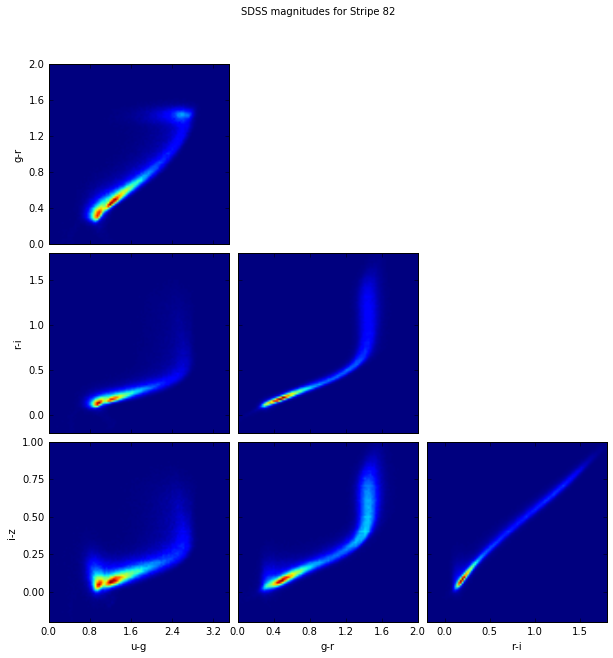

In [22]:
labels = ['u-g', 'g-r', 'r-i', 'i-z']

bins = [np.linspace(0.0, 3.5, 100),
        np.linspace(0, 2, 100),
        np.linspace(-0.2, 1.8, 100),
        np.linspace(-0.2, 1.0, 100)]

fig = plt.figure(figsize=(10, 10))
ax = MultiAxes(4, hspace=0.05, wspace=0.05, fig=fig)

ax.density(stripe82arr, bins=bins)
ax.set_labels(labels)
ax.set_locators(plt.MaxNLocator(5))
plt.suptitle('SDSS magnitudes for Stripe 82')
#savefig('stripe82', bbox_inches='tight')